In [1]:
import matplotlib.path as mpath


In [2]:
import decam2hp

In [3]:
def get_ccd_corners(ccd):
    # Open the file
    with open('zeroed_corners.list', 'r') as file:
        # Read the header line
        header = file.readline().strip().split(',')

        # Find the column index for the specified CCD
        ccd_index = header.index('CCD')
        ccd = f'{ccd}.0'
        
        # Find the column indices for the corner coordinates
        corner1_ra_index = header.index('Corner 1 Ra')
        corner1_dec_index = header.index('Corner 1 Dec')
        corner2_ra_index = header.index('Corner 2 Ra')
        corner2_dec_index = header.index('Corner 2 Dec')
        corner3_ra_index = header.index('Corner 3 Ra')
        corner3_dec_index = header.index('Corner 3 Dec')
        corner4_ra_index = header.index('Corner 4 Ra')
        corner4_dec_index = header.index('Corner 4 Dec')

        # Iterate through the file lines
        for line in file:
            # Split the line into columns
            columns = line.strip().split(',')

            # Check if the CCD matches the specified value
            #print(columns[ccd_index], ccd)
            if columns[ccd_index] == ccd:
                # Extract the corner coordinates
#                 corner1 = [float(columns[corner1_ra_index]), float(columns[corner1_dec_index])]
#                 corner2 = [float(columns[corner2_ra_index]), float(columns[corner2_dec_index])]
#                 corner3 = [float(columns[corner3_ra_index]), float(columns[corner3_dec_index])]
#                 corner4 = [float(columns[corner4_ra_index]), float(columns[corner4_dec_index])]
                value = 1
                corner1 = [value*float(columns[corner1_ra_index]), value*float(columns[corner1_dec_index])]
                corner2 = [value*float(columns[corner2_ra_index]), value*float(columns[corner2_dec_index])]
                corner3 = [value*float(columns[corner3_ra_index]), value*float(columns[corner3_dec_index])]
                corner4 = [value*float(columns[corner4_ra_index]), value*float(columns[corner4_dec_index])]
                # Return the list of corner coordinates
                return [corner1, corner2, corner3, corner4]

    # If the CCD is not found, return None
    return None


In [4]:
import numpy as np
radius = 1.4
n=100
xs = np.linspace(-radius, radius, n)
ys = np.linspace(-radius, radius, n)
    
xlist = []
ylist = []

for x in xs:
    for y in ys:
            xlist.append(x)
            ylist.append(y)
    
ra = np.array(xlist)
dec = np.array(ylist) 
    
i_possible = decam2hp.isCatalogInHex(0, 0, ra, dec)
ra = ra[i_possible]
dec = dec[i_possible]


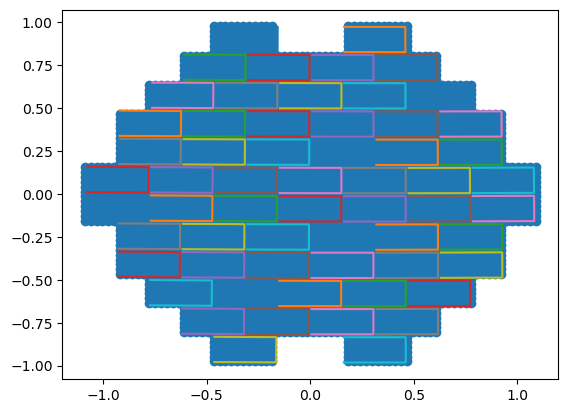

In [5]:
import matplotlib.pyplot as plt;plt.ion()
ccd_numbers = np.arange(1, 63)
ixs = np.where((ccd_numbers != 2) & (ccd_numbers != 61) )
ccd_numbers = ccd_numbers[ixs]


plt.clf()

plt.scatter(ra, dec)
for ccd in ccd_numbers:
    corners = get_ccd_corners(ccd)
    x, y = zip(*corners)
    plt.plot(x, y)
# corners_for_1 = get_ccd_corners(1)
# print(corners_for_1)
# import matplotlib.pyplot as plt
# x, y = zip(*corners_for_1)
# plt.ion()
# plt.scatter(x, y)



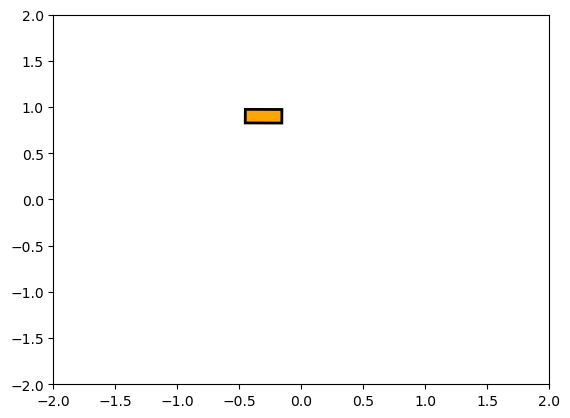

In [6]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches   

def ccd_outlines(ccd_corners):
    # Create a matplotlib Path object
    path_data = []
    for i, (ra, dec) in enumerate(ccd_corners):
#         path_data.append([ra, dec])
        if i == 0:
            # Move to the first corner
            path_data.append((mpath.Path.MOVETO, (ra, dec)))
        else:
            # Draw a line to the next corner
            path_data.append((mpath.Path.LINETO, (ra, dec)))

    # Close the path
    path_data.append((mpath.Path.CLOSEPOLY, (ccd_corners[0][0], ccd_corners[0][1])))

#    Create the matplotlib Path
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
#     path = mpath.Path(path_data)

    return path

ccd_corner_1 = get_ccd_corners(1)
path = ccd_outlines(ccd_corner_1)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()


In [7]:
def get_ipossible(raCenter = 0.0, decCenter=0.0, n=1000, radius=1.4):
    xs = np.linspace(-radius, radius, n)
    ys = np.linspace(-radius, radius, n)
    
    xlist = []
    ylist = []

    for x in xs:
        for y in ys:
            xlist.append(x)
            ylist.append(y)

    ra = np.array(xlist)
    dec = np.array(ylist) 
    
    i_possible = decam2hp.isCatalogInHex(raCenter, decCenter, ra, dec)

    return(ra[i_possible], dec[i_possible], np.ones(i_possible.size))



def sky_fraction(ra, dec, gridsize, raCenter=0.0, decCenter=0.0, fraction=True):
    #creating a grid
    n_possible = gridsize
    
    #making an array of the ccd numbers, without missing ccds
    ccd_numbers = np.arange(1, 63)
    ixs = np.where((ccd_numbers != 2) & (ccd_numbers != 61) )
    ccd_numbers = ccd_numbers[ixs]

    covered_by_ccds = np.zeros(ra.size)
    nhit = 0.0

    for ccd in ccd_numbers:

        ccd_corners = get_ccd_corners(ccd)


        ccd_modified = ccd_corners.copy()  # Make a copy of ccd_corners
        
        for corner in ccd_modified:
            corner[0] = corner[0] - raCenter
            corner[1] = corner[1] - decCenter

        ccdoutline = ccd_outlines(ccd_modified)
        
        mask = ccdoutline.contains_points(tuple(zip(ra, dec)))

        covered_by_ccds += mask
        nhit += np.sum(mask)
        #remember to look at the bounding boxes of the ccds divided by the number inside the ccds -- which 
        #goes outside the ccd loop
    
    if fraction == True:
        fraction = nhit / n_possible
        print(f'nhit={nhit}, radius = {radius}, frac = {fraction:0.2%}')
        return fraction
    else:
        return covered_by_ccds


In [8]:
def fraction_sky_covered(offsets, n=1000, radius=1.4):
    ra, dec, i_possible = get_ipossible(raCenter = 0.0, decCenter = 0.0, 
                                        n = n, radius = radius)
    mask_total = np.zeros(ra.size)
    for i in range(len(offsets)):
        mask = sky_fraction(ra, dec, gridsize = i_possible.size, 
                            raCenter=offsets[i][0], 
                            decCenter =offsets[i][1], fraction=False)

        mask_total += mask

    
#     print(mask_total.size)
    ix, = np.where(mask_total != 0)
    print(ix.size)
    print(i_possible.size)

    mask_covered = ix.size
#     print(mask_covered, i_possible.size)
    fracs = mask_covered/i_possible.size
    print(f'Fraction covered by dithers is {fracs:0.3%}')
    return(fracs)
        

In [9]:
offsets = [[0.000, 0.000]]
fraction_sky_covered(offsets, n=1000)
offsets = [[0.000, 0.000], [0.06389, 0.287436]]
fraction_sky_covered(offsets, n=1000)
offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264]]
fraction_sky_covered(offsets, n=1000)
offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264],[-0.0479175, 0.388884]]
fraction_sky_covered(offsets, n=1000)

offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264],[-0.0479175, 0.388884], 
          [-0.76668, 0.473424 ]]
fraction_sky_covered(offsets, n=1000)
#offsets = [[0.000, 0.000]]
# print(offsets[0], offsets[1])



334384
396548
Fraction covered by dithers is 84.324%
378025
396548
Fraction covered by dithers is 95.329%
389507
396548
Fraction covered by dithers is 98.224%
390066
396548
Fraction covered by dithers is 98.365%
390310
396548
Fraction covered by dithers is 98.427%


0.9842692435720266

In [10]:
offsets = [[0.000, 0.000]]
fraction_sky_covered(offsets, n=100)
offsets = [[0.000, 0.000], [0.06389, 0.287436]]
fraction_sky_covered(offsets, n=100)
offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264]]
fraction_sky_covered(offsets, n=100)
offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264],[-0.0479175, 0.388884]]
fraction_sky_covered(offsets, n=100)

offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264],[-0.0479175, 0.388884], 
          [-0.76668, 0.473424 ]]
fraction_sky_covered(offsets, n=100)

3283
3852
Fraction covered by dithers is 85.228%
3712
3852
Fraction covered by dithers is 96.366%
3790
3852
Fraction covered by dithers is 98.390%
3798
3852
Fraction covered by dithers is 98.598%
3801
3852
Fraction covered by dithers is 98.676%


0.9867601246105919

In [11]:
all_offsets = [[0.000, 0.000], [0.06389, 0.287436], 
           [-0.2395875, -0.135264],[-0.0479175, 0.388884], 
           [-0.76668, 0.473424 ], [-0.4632025, 0.490332], 
           [0.9423775, 0.405792], [-0.543065, -0.828492],
           [0.76668, 0.4227], [0.0479175, 0.777768],
           [-0.5257, 0.7222], [-1.1388, 0.0166], 
           [0.0484, -0.6725], [0.9423775, -0.405792]]

In [48]:
print(template_ras)

[50.5086, 50.5086, 48.193846, 49.996379, 48.140417]


In [ ]:

def ccd_outlines(ccd_corners):
    # Create a matplotlib Path object
    path_data = []
    for i, (ra, dec) in enumerate(ccd_corners):
#         path_data.append([ra, dec])
        if i == 0:
            # Move to the first corner
            path_data.append((mpath.Path.MOVETO, (ra, dec)))
        else:
            # Draw a line to the next corner
            path_data.append((mpath.Path.LINETO, (ra, dec)))

    # Close the path
    path_data.append((mpath.Path.CLOSEPOLY, (ccd_corners[0][0], ccd_corners[0][1])))

#    Create the matplotlib Path
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)
#     path = mpath.Path(path_data)

    return path

ccd_corner_1 = get_ccd_corners(1)
path = ccd_outlines(ccd_corner_1)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='orange', lw=2)
ax.add_patch(patch)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

In [47]:
#get ras and decs from exposures.list

from astropy.io import ascii

expsf = open('/data/des80.a/data/desgw/DEBASS/2021fxy/gw_workflow/exposures.list')
expdata = expsf.readlines()[1:]
expsf.close()

template_ras = []
template_decs = []

z_exposures = [597598, 597258, 595859, 400814, 390188]
#z_exposures = [1118762, 1113812, 1115859, 1112643, 1112628, 111155, 1110284, 794599, 794588, 794208, 794206, 714179, 712833, 712830, 712827, 712824, 699277, 699274, 697362, 697359, 621548, 610033, 605655]
for exp in expdata:
    expos = int(exp.split()[0])
    if expos in z_exposures:
        try:
            teff = float(exp.split()[9])
            if teff > 0.1:
                template_ras.append(float(exp.split()[3]))
                template_decs.append(float(exp.split()[4]))
        except:
            continue

# table_loc = '/data/des70.a/data/eliseke/gw_workflow/exposures.list'
# data = ascii.read(table_loc) 
# print(data['expnum'][0:10])
# exposures_list = 

# mask = np.where(exposures_list['expnum'] == 

# ras = []
# decs = []

# ras.append(exposures_list[mask]['radeg'])
# decs.append(exposures_list[mask]['decdeg'])

In [49]:
def get_ipossible(raCenter = 0.0, decCenter=0.0, n=1000, radius=1.4):
    xs = np.linspace(-radius, radius, n)
    ys = np.linspace(-radius, radius, n)
    
    xlist = []
    ylist = []

    for x in xs:
        for y in ys:
            xlist.append(x+raCenter)
            ylist.append(y+decCenter)

    ra = np.array(xlist)
    dec = np.array(ylist) 
    
    i_possible = decam2hp.isCatalogInHex(raCenter, decCenter, ra, dec)
#     print(i_possible)

    return(ra[i_possible], dec[i_possible], np.ones(i_possible.size))
def ccd_outlines(ccd_corners):
    # Create a matplotlib Path object
    path_data = []
    for i, (ra, dec) in enumerate(ccd_corners):
#         path_data.append([ra, dec])
        if i == 0:
            # Move to the first corner
            path_data.append((mpath.Path.MOVETO, (ra, dec)))
        else:
            # Draw a line to the next corner
            path_data.append((mpath.Path.LINETO, (ra, dec)))

    # Close the path
    path_data.append((mpath.Path.CLOSEPOLY, (ccd_corners[0][0], ccd_corners[0][1])))

#    Create the matplotlib Path
    codes, verts = zip(*path_data)
    path = mpath.Path(verts, codes)

    return path

def sky_fraction(ra, dec, gridsize, raCenter=0.0, decCenter=0.0, plot=False, offset = [0, 0]):
    #creating a grid
    n_possible = gridsize
    
    #making an array of the ccd numbers, without missing ccds
    ccd_numbers = np.arange(1, 63)
    ixs = np.where((ccd_numbers != 2) & (ccd_numbers != 61) )
    ccd_numbers = ccd_numbers[ixs]

    all_covered_ras = []
    all_covered_decs = []
    patchlist = []
    

    for ccd in ccd_numbers:

        ccd_corners = get_ccd_corners(ccd)


        ccd_modified = ccd_corners.copy()  # Make a copy of ccd_corners
#         print(f'before: {ccd_modified}')
        for corner in ccd_modified:
            corner[0] = corner[0] + raCenter + offset[0]
            corner[1] = corner[1] + decCenter + offset[1]
#         print(f'after: {ccd_modified}')

        ccdoutline = ccd_outlines(ccd_modified)
        
        mask = ccdoutline.contains_points(tuple(zip(ra, dec)))
#         print(mask[np.where(mask == True)])
        covered = list(tuple(zip(ra, dec)))
#         print(len(covered))
        indices = np.arange(0, len(covered))
#         print(indices)
#         print(len(indices))
#         print(mask)
        covered_indices = indices[mask]
#         print(covered_indices)
        if len(covered_indices) != 0:
            covered_coords = np.array(covered)[np.array(covered_indices)]
#             print(covered_coords)
            for coord in covered_coords:
                all_covered_ras.append(coord[0])
                all_covered_decs.append(coord[1])
#             all_covered.append(covered_coords)
        if plot == True:
            patch = patches.PathPatch(ccdoutline, facecolor='orange', lw=2)
            patchlist.append(patch)
    if plot == True:
        return all_covered_ras, all_covered_decs, patchlist
    return all_covered_ras, all_covered_decs

def fraction_sky_covered(offset, raCenter, decCenter, n=1000, radius=1.4, plot=True):
    
    #get i_possible for given set of ras and decs
    ra, dec, i_possible = get_ipossible(raCenter = raCenter + offset[0], decCenter = decCenter + offset[1], 
                                        n = n, radius = radius)
#     print(f'ra: {ra} dec:{dec}')
#     fig, ax = plt.subplots()
    all_covered_ras, all_covered_decs, patchlist = sky_fraction(ra, dec, gridsize = i_possible.size, raCenter = raCenter, decCenter = decCenter, plot=plot, offset=offset)
#     for patch in patchlist:
#         ax.add_patch(patch)
#     ax.set_xlim(-162, -164.5)
#     ax.set_ylim(-24, -27)
    return all_covered_ras, all_covered_decs

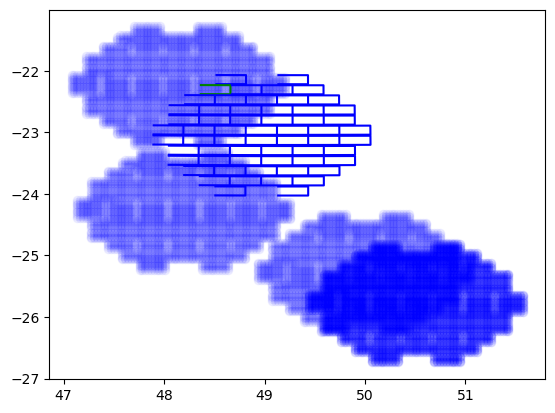

In [51]:
#with nora and maria
import matplotlib.pyplot as plt;plt.ion()

fig, ax = plt.subplots()
thisra = 48.9743625
thisdec = - 23.0448222

everyra = []
everydec = []

for i in range(len(template_ras)):
    thisra = template_ras[i]
    thisdec = template_decs[i]
    cov_ra, cov_dec = fraction_sky_covered([0, 0], thisra, thisdec, n=100)
    everyra.append(cov_ra)
    everydec.append(cov_dec)
    # print(everyra, everydec)

plt.scatter(everyra, everydec, alpha = 0.05, color='blue')


thisra = 48.9743625
thisdec = - 23.0448222
for ccd in ccd_numbers:
        if ccd == 4:
            color = 'green'
        else:
            color = 'blue'
        corners = get_ccd_corners(ccd)
        x, y = zip(*corners)
        x = np.array(x) + thisra
        y = np.array(y) + thisdec
        # plt.xlim(4.5, 50.5)
        # plt.ylim(-25, -21)
        
        plt.plot(x, y, color=color)
      
# plt.scatter(ra, dec)

# for i in range(len(template_ras)):
    # thisra = template_ras[i]
    # thisdec = template_decs[i]
    # for ccd in ccd_numbers:
    #     corners = get_ccd_corners(ccd)
    #     x, y = zip(*corners)
    #     x = np.array(x) + thisra
    #     y = np.array(y) + thisdec
    #     # plt.xlim(4.5, 50.5)
    #     # plt.ylim(-25, -21)
        
    #     plt.plot(x, y)